# OmniFold with ALEPH Open Data

### Imports

In [1]:
import os

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import energyflow as ef
import energyflow.archs
import matplotlib.pyplot as plt
import numpy as np
import uproot

import omnifold
import modplot
import ibu

Instructions for updating:
non-resource variables are not supported in the long term


### Plot Style

In [2]:
#plt.rcParams['figure.figsize'] = (4,4)
#plt.rcParams['figure.dpi'] = 120
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True

## Loading the Data

In [3]:
aleph_path = '/Users/anthonybadea/Documents/ALEPH/ALEPH'
event_selections = [
    'passesNTupleAfterCut',
    'passesTotalChgEnergyMin', 
    'passesNTrkMin', 
    'passesNeuNch',
    'passesSTheta'
]

In [4]:
data_years = [
    #'1992', 
    #'1993', 
    '1994', 
    #'1995'
]

# load data by year
data = {'yearly_thrust': [], 'yearly_evmask': []}
for year in data_years:
    data_file = uproot.open(os.path.join(aleph_path, 'LEP1Data{}_recons_aftercut-MERGED.root'.format(year)))
    t = data_file['t']
    
    event_mask = np.ones(t.num_entries, dtype=bool) # len(t['EventNo'])
    for evsel in event_selections:
        event_mask = np.logical_and(event_mask,t[evsel].array()) #&= t[evsel].array()
        
    data['yearly_evmask'].append(event_mask)
    data['yearly_thrust'].append(1 - t['Thrust'].array())

data['evmask'] = np.concatenate(data['yearly_evmask'])
data['thrust'] = np.concatenate(data['yearly_thrust'])
data['sel_thrust'] = data['thrust'][data['evmask']]
data['log_thrust'] = np.log(data['thrust'])
data['log_sel_thrust'] = np.log(data['sel_thrust'])

In [6]:
# load mc, currently just get thrust values
mc_file = uproot.open(os.path.join(aleph_path, 'alephMCRecoAfterCutPaths_1994.root'))

event_mask = np.ones(mc_file['t'].num_entries, dtype=bool)
before_masks = []
for evsel in event_selections:
    event_mask = np.logical_and(event_mask,mc_file['t'][evsel].array()) #&=mc_file['t'][evsel].array()
    before_masks.append(mc_file['tgenBefore'][evsel].array())
    
mc = {
    'log_sim_thrust': np.log(1 - mc_file['t']['Thrust'].array()),
    'log_gen_thrust': np.log(1 - mc_file['tgen']['Thrust'].array()),
    'log_genBefore_thrust': np.log(1 - mc_file['tgenBefore']['Thrust'].array()),
}
mc['log_sel_sim_thrust'] = mc['log_sim_thrust'][event_mask]
mc['log_sel_gen_thrust'] = mc['log_gen_thrust'][event_mask]

In [7]:
# these dicts are used by OmniFold
nature = {'data_thrust': data['log_sel_thrust']}
synthetic = {'sim_thrust': mc['log_sel_sim_thrust'], 'gen_thrust': mc['log_sel_gen_thrust']}

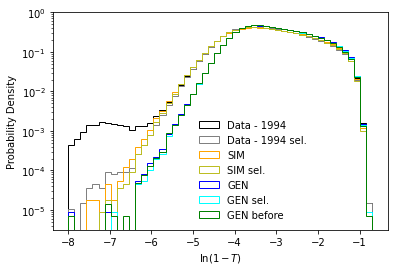

In [8]:
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(-8, np.log(0.5), 51)
density = True

opts = {'bins': bins, 'histtype': 'step', 'density': density}

plt.hist(data['log_thrust'], color='black', label='Data - 1994', **opts)
plt.hist(data['log_sel_thrust'], color='gray', label='Data - 1994 sel.', **opts)

plt.hist(mc['log_sim_thrust'], color='orange', label='SIM', **opts)
simhist = plt.hist(synthetic['sim_thrust'], color='tab:olive', label='SIM sel.', **opts)[0]

plt.hist(mc['log_gen_thrust'], color='blue', label='GEN', **opts)
genhist = plt.hist(synthetic['gen_thrust'], color='cyan', label='GEN sel.', **opts)[0]
genbhist = plt.hist(mc['log_genBefore_thrust'], color='green', label='GEN before', **opts)[0]

plt.yscale('log')

plt.ylim(10**-5.5, 1)

plt.xlabel(r'$\ln(1-T)$')
plt.ylabel('Probability Density')

plt.legend(loc=(0.425, 0.025), frameon=False)

plt.savefig('../plots/LogThrustDistributions.pdf', bbox_inches='tight')
plt.show()

## Specifying the Unfolding Problem

In [9]:
# how many iterations of the unfolding process
itnum = 5

In [10]:
# the observables to use for multifold (a single one just indicates unifold)
obs_multifold = ['LogThrust']

In [11]:
# a dictionary to hold information about the observables
obs = {}

In [12]:
# the thrust and histogram style information
#obs.setdefault('Thrust', {}).update({
#    'func': lambda dset, ptype: dset[ptype + '_thrust'],
#    'nbins_det': 50, 'nbins_mc': 50,
#    'yscale': 'log',
#    'xlim': (0, 0.5), 'ylim': (10**-4.5, 100), 'ylim_ratio': (0.7, 1.3),
#    'ytick_ratio_step': 0.15,
#    'xlabel': r'Thrust $\tau$', 'symbol': r'$\tau$',
#    'ylabel': r'Normalized Cross Section', 'ylabel_ratio': 'Ratio to\nALEPH',
#    'stamp_xy': (0.5, 0.9),
#    'legend_loc': 'lower left', 'legend_ncol': 1
#})

obs.setdefault('LogThrust', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_thrust'],
    'nbins_det': 50, 'nbins_mc': 50,
    'yscale': 'log',
    'xlim': (-8, np.log(0.5)), 'ylim': (10**-5.5, 1), 'ylim_ratio': (0.7, 1.3),
    'ytick_ratio_step': 0.15,
    'xlabel': r'Thrust $\ln(1-T)$', 'symbol': r'$\ln(1-T)$',
    'ylabel': r'Normalized Cross Section', 'ylabel_ratio': 'Ratio to\nGen.',
    'stamp_xy': (0.5, 0.9),
    'legend_loc': 'lower left', 'legend_ncol': 1
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': r'\textsc{Pythia} 6 Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': 'ALEPH Measurement'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

In [13]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['dataobs'] = ob['func'](nature, 'data')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                             ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=50)
    
    print('Done with', obkey)

Done with LogThrust


## OmniFold

In [15]:
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

In [16]:
model_layer_sizes = [100, 100, 100]
val = 0.2

# set up the array of data/simulation detector-level observables
ob0 = obs_multifold[0]
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['dataobs'])), 
                                                np.zeros(len(obs[ob0]['simobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['genobs'])), 
                                                np.zeros(len(obs[ob0]['genobs'])))))

# standardize the inputs
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

# initialize the truth weights to the prior
ws = [winit]

# get permutation for det
perm_det = np.random.permutation(len(winit) + len(wdata))
invperm_det = np.argsort(perm_det)
nval_det = int(val*len(perm_det))
X_det_train, X_det_val = X_det[perm_det[:-nval_det]], X_det[perm_det[-nval_det:]]
Y_det_train, Y_det_val = Y_det[perm_det[:-nval_det]], Y_det[perm_det[-nval_det:]]
del X_det, Y_det

# get an initial permutation for gen and duplicate (offset) it
nval = int(val*len(winit))
baseperm0 = np.random.permutation(len(winit))
baseperm1 = baseperm0 + len(winit)

# training examples are at beginning, val at end
# concatenate into single train and val perms (shuffle each)
trainperm = np.concatenate((baseperm0[:-nval], baseperm1[:-nval]))
valperm = np.concatenate((baseperm0[-nval:], baseperm1[-nval:]))
np.random.shuffle(trainperm)
np.random.shuffle(valperm)

# get final permutation for gen (ensured that the same events end up in val)
perm_gen = np.concatenate((trainperm, valperm))
invperm_gen = np.argsort(perm_gen)
nval_gen = 2*nval
X_gen_train, X_gen_val = X_gen[perm_gen[:-nval_gen]], X_gen[perm_gen[-nval_gen:]]
Y_gen_train, Y_gen_val = Y_gen[perm_gen[:-nval_gen]], Y_gen[perm_gen[-nval_gen:]]
del X_gen, Y_gen

In [17]:
# DCTR, reweights positive distribution to negative distribution
# X: features
# Y: categorical labels
# model: model with fit/predict
# fitargs: model fit arguments
def reweight(X, Y, w, model, filepath, fitargs, val_data=None):

    val_dict = {'validation_data': val_data} if val_data is not None else {}
    model.fit(X, Y, sample_weight=w, **fitargs, **val_dict)
    model.save_weights(filepath)
    preds = model.predict(X, batch_size=10000)[:,1]
    
    # concatenate validation predictions into training predictions
    if val_data is not None:
        preds_val = model.predict(val_data[0], batch_size=10000)[:,1]
        preds = np.concatenate((preds, preds_val))
        w = np.concatenate((w, val_data[2]))

    w *= preds/(1 - preds + 10**-50)
    
    return w

In [18]:
for trw_ind in [0, -2]:

    name = 'LogThrustUnifold_patience-10_batchsize-500_trw{}'.format(trw_ind)
    fitargs = {'epochs': 100, 'batch_size': 500, 'verbose': 2}

    # iterative unfolding
    for i in range(itnum):
        print('Unfolding iteration', i)

        model_det_fp = 'ptktraining/{}_Step-1_Iteration-{}'.format(name, '{}')
        model_mc_fp = 'ptktraining/{}_Step-2_Iteration-{}'.format(name, '{}')

        # define detector reweighting model
        model_det = ef.archs.DNN(input_dim=len(obs_multifold), dense_sizes=model_layer_sizes, patience=10,
                                 #filepath=model_det_fp.format(i) + '_Epoch-{epoch}',
                                 optimizer=Adam(lr=0.0005))

        # define particle reweighting model
        model_mc = ef.archs.DNN(input_dim=len(obs_multifold), dense_sizes=model_layer_sizes, patience=10,
                                #filepath=model_mc_fp.format(i) + '_Epoch-{epoch}',
                                optimizer=Adam(lr=0.0005))

        # load wieghts if not iteration 0
        if i > 0:
            print('Step 1 - loading weights from', model_det_fp.format(i-1))
            model_det.load_weights(model_det_fp.format(i-1))

            print('Step 2 - loading weights from', model_mc_fp.format(i-1))
            model_mc.load_weights(model_mc_fp.format(i-1))

        # step 1: reweight sim to look like data
        w = np.concatenate((wdata, ws[-1]))
        w_train, w_val = w[perm_det[:-nval_det]], w[perm_det[-nval_det:]]
        rw = reweight(X_det_train, Y_det_train, w_train, model_det, model_det_fp.format(i),
                      fitargs, val_data=(X_det_val, Y_det_val, w_val))[invperm_det]
        ws.append(rw[len(wdata):])

        # step 2: reweight the prior to the learned weighting
        w = np.concatenate((ws[-1], ws[trw_ind]))
        w_train, w_val = w[perm_gen[:-nval_gen]], w[perm_gen[-nval_gen:]]
        rw = reweight(X_gen_train, Y_gen_train, w_train, model_mc, model_mc_fp.format(i),
                      fitargs, val_data=(X_gen_val, Y_gen_val, w_val))[invperm_gen]
        ws.append(rw[len(ws[-1]):])

        # save the weights if specified
        np.save(name, ws)

Unfolding iteration 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               200       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_2 (Activation)   (None, 100

/Users/anthonybadea/anaconda3/envs/rpv_multijet/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 1662570 samples, validate on 415642 samples
Epoch 1/100


/Users/anthonybadea/anaconda3/envs/rpv_multijet/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1662570/1662570 - 5s - loss: 0.8877 - acc: 0.5186 - val_loss: 0.8897 - val_acc: 0.6392 - 5s/epoch - 3us/sample
Epoch 2/100
1662570/1662570 - 5s - loss: 0.8854 - acc: 0.5298 - val_loss: 0.8842 - val_acc: 0.4652 - 5s/epoch - 3us/sample
Epoch 3/100
1662570/1662570 - 5s - loss: 0.8850 - acc: 0.5352 - val_loss: 0.8842 - val_acc: 0.5805 - 5s/epoch - 3us/sample
Epoch 4/100
1662570/1662570 - 5s - loss: 0.8849 - acc: 0.5111 - val_loss: 0.8842 - val_acc: 0.4703 - 5s/epoch - 3us/sample
Epoch 5/100
1662570/1662570 - 5s - loss: 0.8849 - acc: 0.5124 - val_loss: 0.8841 - val_acc: 0.5124 - 5s/epoch - 3us/sample
Epoch 6/100
1662570/1662570 - 5s - loss: 0.8849 - acc: 0.5344 - val_loss: 0.8842 - val_acc: 0.5525 - 5s/epoch - 3us/sample
Epoch 7/100
1662570/1662570 - 5s - loss: 0.8849 - acc: 0.5118 - val_loss: 0.8844 - val_acc: 0.6236 - 5s/epoch - 3us/sample
Epoch 8/100
1662570/1662570 - 5s - loss: 0.8849 - acc: 0.5349 - val_loss: 0.8842 - val_acc: 0.5911 - 5s/epoch - 3us/sample
Epoch 9/100
1662570/1662570 

/Users/anthonybadea/anaconda3/envs/rpv_multijet/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1202978 samples, validate on 300744 samples
Epoch 1/100
1202978/1202978 - 4s - loss: 1.2232 - acc: 0.5004 - val_loss: 1.2231 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 2/100
1202978/1202978 - 4s - loss: 1.2216 - acc: 0.4997 - val_loss: 1.2206 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 3/100
1202978/1202978 - 4s - loss: 1.2208 - acc: 0.5001 - val_loss: 1.2206 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 4/100
1202978/1202978 - 4s - loss: 1.2206 - acc: 0.4996 - val_loss: 1.2205 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 5/100
1202978/1202978 - 4s - loss: 1.2205 - acc: 0.5003 - val_loss: 1.2205 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 6/100
1202978/1202978 - 4s - loss: 1.2205 - acc: 0.4998 - val_loss: 1.2205 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 7/100
1202978/1202978 - 4s - loss: 1.2205 - acc: 0.5001 - val_loss: 1.2205 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 8/100
1202978/1202978 - 4s - loss: 1.2205 - acc: 0.4996 - val_loss: 1.2205 - val

Epoch 4/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5351 - val_loss: 0.8828 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 5/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5287 - val_loss: 0.8828 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 6/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5083 - val_loss: 0.8828 - val_acc: 0.6392 - 5s/epoch - 3us/sample
Epoch 7/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5465 - val_loss: 0.8828 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 8/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5355 - val_loss: 0.8828 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 9/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5134 - val_loss: 0.8828 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 10/100
1662570/1662570 - 5s - loss: 0.8835 - acc: 0.5495 - val_loss: 0.8828 - val_acc: 0.6392 - 5s/epoch - 3us/sample
Epoch 11/100
Restoring model weights from the end of the best epoch: 1.
1662570/1662570 - 6s - loss: 0.8835 - acc: 0.5249 - val_loss: 0.88

Epoch 14/100
1662570/1662570 - 5s - loss: 0.8873 - acc: 0.4061 - val_loss: 0.8867 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 15/100
Restoring model weights from the end of the best epoch: 5.
1662570/1662570 - 5s - loss: 0.8873 - acc: 0.4208 - val_loss: 0.8867 - val_acc: 0.3608 - 5s/epoch - 3us/sample
Epoch 00015: early stopping
Train on 1202978 samples, validate on 300744 samples
Epoch 1/100
1202978/1202978 - 4s - loss: 1.2251 - acc: 0.5000 - val_loss: 1.2251 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 2/100
1202978/1202978 - 4s - loss: 1.2251 - acc: 0.5003 - val_loss: 1.2251 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 3/100
1202978/1202978 - 4s - loss: 1.2251 - acc: 0.5003 - val_loss: 1.2251 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 4/100
1202978/1202978 - 4s - loss: 1.2251 - acc: 0.4999 - val_loss: 1.2251 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 5/100
1202978/1202978 - 4s - loss: 1.2251 - acc: 0.4995 - val_loss: 1.2251 - val_acc: 0.5000 - 4s/epoch - 3us/samp

1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5003 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 6/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5001 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 7/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5008 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 8/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.4996 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 9/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.4999 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 10/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5001 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 11/100
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5012 - val_loss: 1.2246 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 12/100
Restoring model weights from the end of the best epoch: 2.
1202978/1202978 - 4s - loss: 1.2246 - acc: 0.5003 - val_loss: 1.2246 - val_ac

Epoch 17/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.4998 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 18/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.5000 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 19/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.5005 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 20/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.4997 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 21/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.5003 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 4us/sample
Epoch 22/100
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.4999 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 23/100
Restoring model weights from the end of the best epoch: 13.
1202978/1202978 - 4s - loss: 1.2255 - acc: 0.4997 - val_loss: 1.2255 - val_acc: 0.5000 - 4s/epoch - 3us/sample
Epoch 00023: early stopping
Unfolding iteration 0
Model: "model_10"
____

Epoch 14/100
Restoring model weights from the end of the best epoch: 4.
1202978/1202978 - 5s - loss: 1.2317 - acc: 0.4995 - val_loss: 1.2316 - val_acc: 0.5000 - 5s/epoch - 4us/sample
Epoch 00014: early stopping
Unfolding iteration 1
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               200       
                                                                 
 activation_48 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_49 (Activation)  (None, 100)               0         
                       

Step 2 - loading weights from ptktraining/LogThrustUnifold_patience-10_batchsize-500_trw-2_Step-2_Iteration-1
Train on 1662570 samples, validate on 415642 samples
Epoch 1/100
1662570/1662570 - 6s - loss: 0.8839 - acc: 0.5279 - val_loss: 0.8832 - val_acc: 0.5876 - 6s/epoch - 4us/sample
Epoch 2/100
1662570/1662570 - 6s - loss: 0.8839 - acc: 0.5285 - val_loss: 0.8832 - val_acc: 0.6023 - 6s/epoch - 3us/sample
Epoch 3/100
1662570/1662570 - 6s - loss: 0.8839 - acc: 0.5367 - val_loss: 0.8833 - val_acc: 0.5644 - 6s/epoch - 3us/sample
Epoch 4/100
1662570/1662570 - 6s - loss: 0.8839 - acc: 0.5316 - val_loss: 0.8832 - val_acc: 0.6204 - 6s/epoch - 3us/sample
Epoch 5/100
1662570/1662570 - 6s - loss: 0.8838 - acc: 0.5230 - val_loss: 0.8832 - val_acc: 0.5974 - 6s/epoch - 3us/sample
Epoch 6/100
1662570/1662570 - 6s - loss: 0.8838 - acc: 0.5207 - val_loss: 0.8832 - val_acc: 0.6027 - 6s/epoch - 3us/sample
Epoch 7/100
1662570/1662570 - 6s - loss: 0.8838 - acc: 0.5285 - val_loss: 0.8832 - val_acc: 0.5908 

Epoch 8/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4603 - val_loss: 0.8866 - val_acc: 0.4248 - 6s/epoch - 3us/sample
Epoch 9/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4671 - val_loss: 0.8866 - val_acc: 0.4396 - 6s/epoch - 3us/sample
Epoch 10/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4608 - val_loss: 0.8866 - val_acc: 0.4283 - 6s/epoch - 3us/sample
Epoch 11/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4589 - val_loss: 0.8866 - val_acc: 0.4355 - 6s/epoch - 3us/sample
Epoch 12/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4547 - val_loss: 0.8866 - val_acc: 0.6003 - 6s/epoch - 3us/sample
Epoch 13/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4654 - val_loss: 0.8867 - val_acc: 0.4259 - 6s/epoch - 3us/sample
Epoch 14/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4632 - val_loss: 0.8866 - val_acc: 0.4423 - 6s/epoch - 3us/sample
Epoch 15/100
1662570/1662570 - 6s - loss: 0.8872 - acc: 0.4572 - val_loss: 0.8866 - val_acc: 0.4404 - 6s/epoch - 3us/sample
Epoch 16/1

1662570/1662570 - 6s - loss: 0.8877 - acc: 0.4579 - val_loss: 0.8871 - val_acc: 0.4314 - 6s/epoch - 3us/sample
Epoch 3/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4478 - val_loss: 0.8871 - val_acc: 0.4300 - 6s/epoch - 4us/sample
Epoch 4/100
1662570/1662570 - 6s - loss: 0.8877 - acc: 0.4522 - val_loss: 0.8871 - val_acc: 0.5950 - 6s/epoch - 4us/sample
Epoch 5/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4544 - val_loss: 0.8871 - val_acc: 0.4095 - 6s/epoch - 4us/sample
Epoch 6/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4481 - val_loss: 0.8871 - val_acc: 0.4302 - 6s/epoch - 4us/sample
Epoch 7/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4539 - val_loss: 0.8874 - val_acc: 0.3938 - 6s/epoch - 4us/sample
Epoch 8/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4474 - val_loss: 0.8871 - val_acc: 0.4275 - 6s/epoch - 3us/sample
Epoch 9/100
1662570/1662570 - 6s - loss: 0.8878 - acc: 0.4476 - val_loss: 0.8871 - val_acc: 0.6113 - 6s/epoch - 3us/sample
Epoch 10/100
1662570/1662570

## Plot Unfolding Results

In [20]:
with open(os.path.join(aleph_path,'HEPData-ins636645-v1-Table_54.csv'), 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


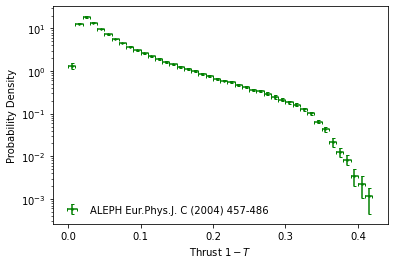

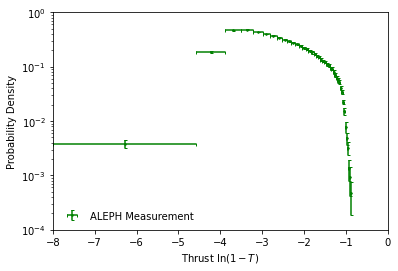

In [21]:
aleph_bins = 1 - np.append(1.0, hepdata[::-1,1])
aleph_midbins = (aleph_bins[1:] + aleph_bins[:-1])/2
aleph_thrust = hepdata[::-1,3]
aleph_thrust_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
assert np.all(aleph_bins[1:] == 1 - hepdata[::-1,1]) and np.all(aleph_bins[:-1] == 1 - hepdata[::-1,2])

plt.errorbar(aleph_midbins, aleph_thrust, xerr=0.005, yerr=aleph_thrust_errs, label='ALEPH Eur.Phys.J. C (2004) 457-486',
             color='green', **modplot.style('errorbar'))
plt.yscale('log')
plt.xlabel('Thrust $1 - T$')
plt.ylabel('Probability Density')
plt.legend(loc='lower left', frameon=False)
plt.show()

aleph_log_bins = np.log(aleph_bins + np.exp(-8))
aleph_log_midbins = (aleph_log_bins[1:] + aleph_log_bins[:-1])/2
log_binwidths = aleph_log_bins[1:] - aleph_log_bins[:-1]
aleph_log_thrust = aleph_thrust * 0.01 / log_binwidths
aleph_log_thrust_errs = aleph_thrust_errs * 0.01 / log_binwidths

plt.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH Measurement',
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, **modplot.style('errorbar'))
plt.yscale('log')
plt.xlim(-8, 0)
plt.ylim(10**-4, 1)
plt.xlabel(r'Thrust $\ln(1 - T)$')
plt.ylabel('Probability Density')
plt.legend(loc='lower left', frameon=False)
plt.show()

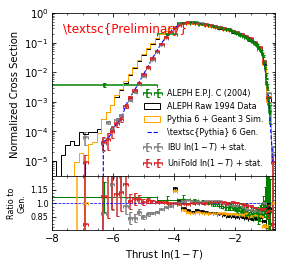

In [24]:
obkey = 'LogThrust'
ob = obs['LogThrust']
corrs = np.ones(genbhist.shape)
corrs = genbhist/(genhist + 10**-50)

# convert obs to numpy
ob["genobs"] = np.array(ob["genobs"])
ob["dataobs"] = np.array(ob["dataobs"])
ob["simobs"] = np.array(ob["simobs"])

omnifold_ws = np.load('LogThrustUnifold_patience-10_batchsize-500_trw0.npy')
#omnifold_ws = np.load('LogThrustUnifold.npy')

fig, [ax0, ax1] = modplot.axes(**ob, gridspec_update={'height_ratios': (3, 1)})
if ob.get('yscale') is not None:
    ax0.set_yscale(ob['yscale'])

# plot the "data" histogram of the observable
ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='ALEPH Raw 1994 Data', **hist_style)

# plot the "sim" histogram of the observable
ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Pythia 6 + Geant 3 Sim.', **hist_style)

# plot the "gen" histogram of the observable
ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

# plot the IBU distribution
ibu_hist = ob['ibu_phis'][itnum]*corrs
ax0.errorbar(ob['midbins_mc'], ibu_hist, xerr=ob['binwidth_mc']/2, yerr=ob['ibu_phi_unc']*corrs,
             color='gray', label='IBU {} + stat.'.format(ob['symbol']), **modplot.style('errorbar'))

# plot the UniFold distribution
omnifold_hist, omnifold_errs = modplot.calc_hist(ob['genobs'], bins=ob['bins_mc'], 
                                                 weights=omnifold_ws[-5], density=True)[:2]
ax0.errorbar(ob['midbins_mc'], omnifold_hist, xerr=ob['binwidth_mc']/2, yerr=omnifold_errs*corrs,
             color='tab:red', label='UniFold {} + stat.'.format(ob['symbol']), **modplot.style('errorbar'))

# plot the ALEPH measurement
ax0.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH E.P.J. C (2004)',
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, **modplot.style('errorbar'))

# RATIO PLOTS
ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='blue', lw=0.75)
genobs_hist, genobs_errs = modplot.calc_hist(ob['genobs'], bins=ob['bins_mc'], density=True)[:2]

# central value calculations
gen_hist_aleph_bins = modplot.calc_hist(ob['genobs'], bins=aleph_log_bins, density=False)[0]
gen_hist_aleph_bins /= log_binwidths * np.sum(gen_hist_aleph_bins)
aleph_ratio = aleph_log_thrust/(gen_hist_aleph_bins + 1e-50)
ibu_ratio = ibu_hist/(genobs_hist + 10**-50)
omnifold_ratio = omnifold_hist*corrs/(genobs_hist + 1e-50)

# error calculations
aleph_unc_ratio = aleph_log_thrust_errs/(gen_hist_aleph_bins + 10**-50)
ibu_unc_ratio = ob['ibu_phi_unc']*corrs/(genobs_hist + 10**-50)
omnifold_unc_ratio = omnifold_errs*corrs/(genobs_hist + 10**-50)

# plot ALEPH ratio
ax1.errorbar(aleph_log_midbins, aleph_ratio, xerr=log_binwidths/2, yerr=aleph_unc_ratio,
             color='green', **modplot.style('errorbar', lw=1))

# data ratio
data_hist, data_errs = modplot.calc_hist(ob['dataobs'], bins=ob['bins_det'], density=True)[:2]
ax1.errorbar(ob['midbins_det'], data_hist/(genobs_hist + 10**-50), xerr=ob['binwidth_det']/2,
             yerr=data_errs/(genobs_hist + 10**-50), color='black', **modplot.style('errorbar'))

# sim ratio
sim_hist, sim_errs = modplot.calc_hist(ob['simobs'], bins=ob['bins_det'], density=True)[:2]
ax1.errorbar(ob['midbins_det'], sim_hist/(genobs_hist + 10**-50), xerr=ob['binwidth_det']/2,
             yerr=sim_errs/(genobs_hist + 10**-50), color='orange', **modplot.style('errorbar'))

# plot IBU ratio
ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio,
             color=ibu_style['color'], **modplot.style('errorbar'))

# plot OmniFold ratio
ax1.errorbar(ob['midbins_mc'], omnifold_ratio, xerr=ob['binwidth_mc']/2, yerr=omnifold_unc_ratio,
             color='tab:red', **modplot.style('errorbar'))

ax1.fill_between(ob['midbins_mc'], 1 - genobs_errs, 1 + genobs_errs, facecolor='blue', zorder=-2)

loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
order = [5, 1, 2, 0, 3, 4]
modplot.legend(ax=ax0, frameon=False, loc=(0.4, 0.025), order=order, fontsize=8, markerscale=0)

modplot.stamp(0.05, 0.9, ax=ax0, textops_update={'color': 'red', 'fontsize': 12},
              line_0=r'\textsc{Preliminary}')

modplot.save(fig, 'LogThrustWithUniFold', tx=44, ty=252.75)
#fig.show()